# Hands-On 2: Parallelization with OpenMP

Welcome to Hands-on _Parallelization with OpenMP_. This notebook comprises 3 sessions. Next table shows the documents and files needed to develop each one of the exercises.

|  Sessions     | Codes               | files              | 
| --------------| --------------------| ------------------ |
| Session 1     | Numeric Integration |  integral.c        |  
| Session 2     | Image Processing    |  image.c, lenna.ppm |   
| Session 3     | Prime numbers       |  big_prime.c, count_primes.c |   

## `Numeric Integration`

The definite integral of a given function f(x) in the interval [a,b] can be defined as:

$$ \int_{a}^{b}{f(x) dx} $$

In this exercise we will compute an approximation of the integral by summing the area of a set of rectangles that occupy a similar area as the one of the integral. Figure 1 shows an example of the approximation. These approximation can be computed using the following expression:

$$\int_{a}^{b}{f(x) dx} \approx \sum_{i=0}^{n-1} {f(x_i) \cdot h} = 
   h \cdot \sum_{i=0}^{n-1} {f(x_i)}$$

where $n$ is the number of rectangles used, $\frac{(b − a)}{n}$ is the width of the rectangles and, $x_i = a + h * (i + 0.5)$ is the medium point of each rectangle. The accuracy of the approximation depends on the number of rectangles used.

The sequential code of the program is available in the file `integral.c`. 

The objective of this session is to parallelize using OpenMP the computation of the integral. 

### Parallelization the code

The next step will be to modify the code in the file integral.c to perform the computation of the integral in parallel using OpenMP. A first approach could be to use the directive parallel for without considering if variables should be private or shared. By default, all variables are shared. After this change, you can compile and execute the program.

In [5]:
%%writefile integral.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

/* f(x) function from which the integral will be calculated. */
double f(double x){return 100 * x + sin(2 * x * M_PI);}

/* Calculates the integral of the function betweens point a and b. */
double integral(double a, double b, int n)
{
   double h, s = 0, result;
   int i;

   h = (b - a) / n;

   for(i = 0; i < n; i++)
   {
      s += f(a + h * (i + 0.5));
   }
   result = h * s;
   
    return result;
}

int main(int argc, char **argv)
{
   int steps = atoi(argv[1]);
   
   double result = integral(0, 1, steps);
  
   printf("%f\n", result);

   return 0;
}

Overwriting mm.c


### Run the Code

In [ ]:
!gcc integral.c -o integral -lm

In [ ]:
!./integral 1

We can check that the result obtained is incorrect. The problem is that the scope of the variables may be incorrect, resulting in race conditions. To solve this, we should correctly indicate the scope of the variables within the loop, by using clauses such as private or reduction, if necessary. Once the code has been corrected, it can be compiled and executed again. We should check that the result is the sames as using a single thread (or without the `-fopenmp` compiler option) or as using different numbers of threads. Execution should be repeated several times 1.

## `Image Processing`

This practical focuses on the implementation in parallel of an image filtering process based on the median using OpenMP. This API implements a shared-memory parallel model. The objective of this practical is to deepen on the knowledge of OpenMP and the dependencies among processes. The exercise will be based on the sequential version of a program that reads an image in the PPM format (a portable-text based format), applies several filtering steps based on the averaged median with variable radius and writes the resulting image in a file using the same format. The result of the exercise will be a parallel code using OpenMP that exploits the parallelism of the different loops in which the median process consist of.

### Problem Description

Image filtering consists of substituting the values of the pixels in an image by values depending on the values of the neighbors. The image filtering can be used to reduce noise, focus, blur an image, etc. The neighbors of an image are the pixels located, in both directions, not further than a maximum value called the radius. Median filtering notably reduces white noise but introduces a blurring effect. In averaged median, a mask is used to weight the different values of the pixels close to the pixel being processed, following a parabolic or linear adjustment. This filtering provides better results than the simple median, but it has a higher computational cost. Finally, filtering is an iterative process that may involve several sequential steps.

In [7]:
%%writefile image.c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>

#define max(a, b) ((a) > (b) ? (a) : (b))
#define min(a, b) ((a) < (b) ? (a) : (b))
#define MAXCAD 100

#define NUM_STEPS 5
#define RADIUS 8
#define INPUT_IMAGE "./material/session-2/lenna.ppm"
#define OUTPUT_IMAGE "./material/session-2/lenna-fil.ppm"

struct pixel
{
  unsigned char r, g, b;
};

int read_ppm_image(char *file_name, struct pixel ***img, int *out_width, int *out_height)
{
  FILE *fd;
  char type[MAXCAD];
  int rgb_max, actual_width, actual_height, i, j;

  fd = fopen(file_name, "r");
  if (fd == NULL)
  {
    printf("failed opening file %s\n", file_name);
    return -1;
  }

  fscanf(fd, "%s", type);
  if (strcmp(type, "P3") != 0)
  {
    printf("wrong format. P3 format expected\n");
    return -1;
  }

  fscanf(fd, "%d%d", &actual_width, &actual_height);

  if ((*img = (struct pixel **)malloc(sizeof(struct pixel *) * actual_height)) == NULL)
  {
    printf("failed allocating memory for %d rows\n", actual_height);
    return -1;
  }
  if (((*img)[0] = (struct pixel *)malloc(sizeof(struct pixel) * actual_width * actual_height)) == NULL)
  {
    printf("failed de locating memory for %d * %d pixels\n", actual_width, actual_height);
    return -1;
  }
  for (i = 1; i < actual_height; i++)
    (*img)[i] = (*img)[i - 1] + actual_width;

  fscanf(fd, "%d", &rgb_max);

  for (i = 0; i < actual_height; i++)
    for (j = 0; j < actual_width; j++)
    {
      fscanf(fd, "%hhu", &((*img)[i][j].r));
      fscanf(fd, "%hhu", &((*img)[i][j].g));
      fscanf(fd, "%hhu", &((*img)[i][j].b));
    }

  *out_width = actual_height;
  *out_height = actual_width;

  fclose(fd);

  return 0;
}

int write_ppm_image(char *file_name, struct pixel **img, int width, int height)
{
  FILE *fd;
  int rgb_max = 255, i, j;

  fd = fopen(file_name, "w");
  if (fd == NULL)
  {
    printf("failed opening file %s\n", file_name);
    return -1;
  }

  fprintf(fd, "P3\n");
  fprintf(fd, "%d %d\n", height, width);
  fprintf(fd, "%d\n", rgb_max);

  for (i = 0; i < width; i++)
  {
    for (j = 0; j < height; j++)
    {
      fprintf(fd, "%d ", img[i][j].r);
      fprintf(fd, "%d ", img[i][j].g);
      fprintf(fd, "%d ", img[i][j].b);
    }
    fprintf(fd, "\n");
  }

  fclose(fd);

  return 0;
}

int apply_filter(int steps, int radius, struct pixel **src, struct pixel **dst, int width, int height)
{
  int i, j, k, l, s, total;

  struct
  {
    int r, g, b;
  } result;
  int **filter_block, filter_factor;

  if ((filter_block = (int **)malloc(sizeof(int *) * (2 * (radius + 1)))) == NULL)
  {
    printf("failed allocating memory for the filter block\n");
    exit(-1);
  }
  if ((filter_block[0] = (int *)malloc(sizeof(int) * (2 * (radius + 1)) * (2 * (radius + 1)))) == NULL)
  {
    printf("failed allocating memory for the filter block\n");
    exit(-1);
  }
  for (i = 1; i < 2 * (radius + 1); i++)
    filter_block[i] = filter_block[i - 1] + 2 * (radius + 1);

  for (i = -radius; i <= radius; i++)
    for (j = -radius; j <= radius; j++)
      filter_block[i + radius][j + radius] = (radius - abs(i)) * (radius - abs(i)) + (radius - abs(j)) * (radius - abs(j)) + 1;

  for (s = 0; s < steps; s++)
  {
    for (i = 0; i < width; i++)
    {
      for (j = 0; j < height; j++)
      {
        result.r = 0;
        result.g = 0;
        result.b = 0;
        total = 0;
        for (k = max(0, i - radius); k <= min(width - 1, i + radius); k++)
        {
          for (l = max(0, j - radius); l <= min(height - 1, j + radius); l++)
          {
            filter_factor = filter_block[k - i + radius][l - j + radius];
            result.r += src[k][l].r * filter_factor;
            result.g += src[k][l].g * filter_factor;
            result.b += src[k][l].b * filter_factor;
            total += filter_factor;
          }
        }
        result.r /= total;
        result.g /= total;
        result.b /= total;
        dst[i][j].r = result.r;
        dst[i][j].g = result.g;
        dst[i][j].b = result.b;
      }
    }
    if (s + 1 < steps)
      memcpy(src[0], dst[0], width * height * sizeof(struct pixel));
  }
  free(filter_block[0]);
  free(filter_block);
    
  return 0;
}

int main(int argc, char **argv)
{
  struct pixel **src_img, **dst_img;
  int width, height;
  int i, result;

  result = read_ppm_image(INPUT_IMAGE, &src_img, &width, &height);

  dst_img = (struct pixel **)malloc(width * sizeof(struct pixel *));
  dst_img[0] = (struct pixel *)malloc(height * width * sizeof(struct pixel));
  for (i = 1; i < width; i++)
    dst_img[i] = dst_img[i - 1] + height;

  apply_filter(NUM_STEPS, RADIUS, src_img, dst_img, width, height);

  result = write_ppm_image(OUTPUT_IMAGE, dst_img, width, height);

  free(src_img[0]);
  free(dst_img[0]);
  free(src_img);
  free(dst_img);

  printf("filtered image resolution: %dx%d\n", width, height);

  return 0;
}

Overwriting mm.c


### Run the Code

In [ ]:
!gcc image.c -o image -fopenmp

In [ ]:
!./image

### Image before

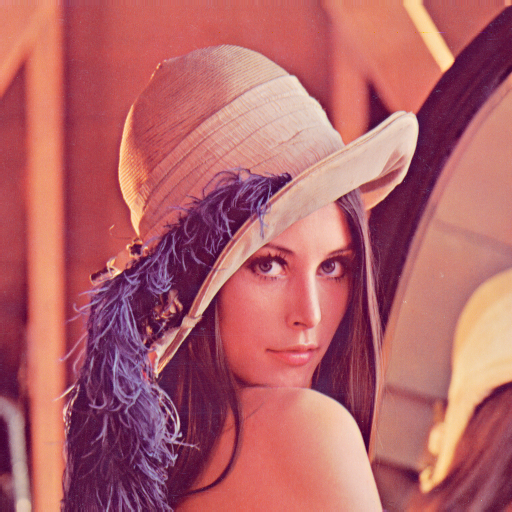

In [7]:
from IPython.display import display
from PIL import Image
path="./material/session-2/lenna.ppm"
display(Image.open(path))

## Filtered image resolution

In [ ]:
from IPython.display import display
from PIL import Image
path="./material/session-2/lenna-fil.ppm"
display(Image.open(path))

## `Primes Numbers`

### Big Prime

In [ ]:
%%writefile big_prime.c
#include <stdio.h>
#include <math.h>
#include <limits.h>

typedef unsigned long long big_integer;
#define BIGGEST_INTEGER ULLONG_MAX

int is_prime(big_integer n)
{
  int result;
  big_integer sq_root;

  result = (n % 2 != 0 || n == 2);

  if (result)
  {
    sq_root = sqrt(n);

    for (big_integer i = 3; result && i <= sq_root; i += 2)
      result = n % i != 0;
  }

  return result;
}

int main(int argc, char **argv)
{
  big_integer n;

  for (n = BIGGEST_INTEGER; !is_prime(n); n -= 2)
  {
  }

  printf("%llu\n", n);

  return 0;
}

### Run the Code

In [ ]:
!gcc big_prime.c -o big_prime -lm

In [ ]:
!./big_prime

### Count Primes

In [ ]:
%%writefile count_primes.c
#include <stdio.h>
#include <math.h>

typedef unsigned long long big_integer;
#define TOP_LIMIT 20000000ULL

int is_prime(big_integer n)
{
  int p;
  big_integer i, s;

  p = (n % 2 != 0 || n == 2);

  if (p)
  {
    s = sqrt(n);

    for (i = 3; p && i <= s; i += 2)
      if (n % i == 0)
        p = 0;
  }

  return p;
}

int main(int argc, char **argv)
{
  big_integer i, primes = 2;

  for (i = 3; i <= TOP_LIMIT; i += 2)
    if (is_prime(i))
      primes++;

  printf("%llu\n", primes);

  return 0;
}

### Run the Code

In [ ]:
!gcc count_primes.c -o count_primes -lm

In [ ]:
!./count_primes

## References

M. Boratto. Hands-On Supercomputing with Parallel Computing. Available: https://github.com/muriloboratto/Hands-On-Supercomputing-with-Parallel-Computing. 2022.

B. Chapman, G. Jost and R. Pas. Using OpenMP: Portable Shared Memory Parallel Programming. The MIT Press, 2007, USA.